In [1]:
import doutils
doutils.nb.megaimport(globals())
%load_ext autoreload
%autoreload 2

In [198]:
from shapely.geometry import box, Polygon
import h3
from cartoframes import list_tables, to_carto
from cartoframes.viz import *
from sf_utils import *
from shapely import wkt
import json

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
for k,v in bboxes.items():
    print(k, box(*v).area)

chicago 0.15773980000000037
los_angeles 0.3547760000000067
buffalo 0.09005879347200096
raleigh 0.02192661899999826


In [199]:
set_default_credentials("/Users/juanluis/Documents/credentials/carto_creds_publications.json")

In [13]:
chosen_categories = [
 'Grocery Stores',
 'Clothing Stores',
 'Sporting Goods, Hobby, and Musical Instrument Stores',
 'General Merchandise Stores, including Warehouse Clubs and Supercenters',
 'Electronics and Appliance Stores']

In [14]:
city_palette = {
    "chicago" : "#855C75",
    "los_angeles" : "#D9AF6B",
    "buffalo" : "#AF6458",
    "raleigh" : "#736F4C"
}

In [15]:
bq_client = get_bq_client()

In [7]:
for city in tqdm(bboxes):
    q = f"""
    SELECT {", ".join(cols)}
    FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_{city}`
    WHERE raw_visit_counts is not null -- and top_category IN {tuple(chosen_categories)}
    AND brands = 'Walmart'
    """
    df = bq_client.query(q).result().to_dataframe()
    df.to_csv(f"walmart_{city}.csv")
    del df
    #walmart_dfs[city] = df

100%|██████████| 1/1 [00:11<00:00, 11.29s/it]


In [10]:
ts_walmart = {}
for city in tqdm(bboxes):
    walmart_df = pd.read_csv(f"walmart_{city}.csv", parse_dates=['date_range_start', 'date_range_end'],index_col=0)
    ts_walmart[city] = explode_daily_counts(walmart_df)

  0%|          | 0/4 [00:00<?, ?it/s]/Users/juanluis/opt/anaconda3/envs/etl/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 4/4 [00:19<00:00,  4.89s/it]


In [11]:
ts_list = []
for city, ts_city in ts_walmart.items():
    ts_city.columns = [f"Walmart {city}"]
    ts_list.append(ts_city)

In [12]:
ts = pd.concat(ts_list, axis = 1)

In [14]:
ts_2019 = ts[(ts.index >= "2019-01-01")&(ts.index < "2019-12-31")]
ts_2020 = ts[(ts.index >= "2020-01-01")&(ts.index < "2020-12-31")]
#ts_2021 = ts[(ts.index >= "2020-01-01")&(ts.index < "2020-12-31")]

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
bf_2019 = np.datetime64("2019-11-29")
bf_2020 = np.datetime64("2020-11-27")
bf_2021 = np.datetime64("2021-11-26")

## Plotting visitors homes from walmart in BF

In [194]:
with open("hotspots_h3_z7.json", "r") as fp:
    hotspots_h3_z7 = json.load(fp)
    
l0 = hotspots_h3_z7["chicago"]

In [197]:
visitors_q = f"""
SELECT EXTRACT(DATE FROM date_range_start) as date,
placekey, visitor_home_cbgs, top_category, h3_z9 FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_weekly_patterns_chicago`
WHERE h3_z7 in {tuple(l0)}
AND top_category in {tuple(chosen_categories)}
"""
chicago_visitors = bq_client.query(visitors_q).result().to_dataframe()

In [9]:
walmart_q = f"""
SELECT EXTRACT(DATE FROM date_range_start) as date,
placekey, street_address, raw_visitor_counts, visitor_home_cbgs, top_category, h3_z9 FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_weekly_patterns_chicago`
WHERE brands  = 'Walmart' 
"""

walmart_pos_q = f"""
SELECT distinct placekey, latitude, longitude FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago`
WHERE brands  = 'Walmart' 
"""

In [13]:
blockgroups_table_id = "carto-do-public-data.carto.geography_usa_blockgroup_2019"

In [1164]:
bbox = bboxes["chicago"]

In [1878]:
blockgroups_q = f"""
SELECT geoid, geom FROM `{blockgroups_table_id}`
WHERE ST_INTERSECTSBOX(geom, {str(bbox)[1: - 1]})
"""

In [14]:
blockgroups_geoms = bq_client.query(blockgroups_q).result().to_dataframe()
blockgroups_gdf = gpd.GeoDataFrame(blockgroups_geoms.geoid, geometry = blockgroups_geoms.geom.apply(wkt.loads))

In [16]:
def generate_walmart_df_for_black_friday(walmart_bf):
    walmart_bf = walmart_bf.copy()
    if isinstance(walmart_bf.visitor_home_cbgs.iloc[0],str):
        walmart_bf.visitor_home_cbgs = walmart_bf.visitor_home_cbgs.apply(lambda x : dict(json.loads(x)))
    
    if "year"  not in walmart_bf:
        walmart_bf["year"] = walmart_bf.date.apply(lambda x : x.year)
    
    result_df = []
    for r in walmart_bf.itertuples():
        tmp = pd.DataFrame([r.visitor_home_cbgs], index = ["visits"]).T
        tmp["walmart"] = "Walmart - " + r.street_address
        tmp["date"] = str(r.date)
        tmp["year"] = str(r.date.year)
        result_df.append(tmp)
    walmart_visits = pd.concat(result_df) #.drop_duplicates()
    unique_blockgroup_ids = walmart_visits.index.unique()
    
    blockgroups_q = f"""
    SELECT geoid, geom FROM `{blockgroups_table_id}`
    WHERE geoid in {tuple(unique_blockgroup_ids)}
    """
    block_groups_geoms = bq_client.query(blockgroups_q).result().to_geodataframe()
    walmart_bf_across_years = pd.merge(block_groups_geoms, walmart_visits, left_on="geoid", right_index = True, how = "right")
    walmart_bf_across_years["total_visits_from_bcg"] = walmart_bf_across_years.groupby(["geoid", "year"]).visits.transform(sum)
    return walmart_bf_across_years.drop_duplicates()
    

In [95]:
def enlarge_bbox(bbox, v):
    xmin, ymin, xmax, ymax = bbox
    return (xmin - v, ymin - v, xmax + v, ymax + v)

In [117]:
def prepare_dataframes_for_map_layers(city_walmart_visitors, city_walmart_positions):
    
    walmart_df = generate_walmart_df_for_black_friday(city_walmart_visitors)
    xmin, ymin, xmax, ymax = enlarge_bbox(bbox, 0.15) # we take a slightly larger bbox to include blockgroups which are further away

    filtered_walmart_df = walmart_df.cx[xmin:xmax, ymin:ymax]

    walmart_geom = gpd.points_from_xy(city_walmart_positions.longitude, city_walmart_positions.latitude)
    gdf_walmart = gpd.GeoDataFrame(city_walmart_positions.placekey, geometry = walmart_geom)
    gdf_walmart = pd.merge(gdf_walmart, city_walmart_visitors[["placekey","street_address", "raw_visitor_counts", "date"]], on = "placekey", how = "left")
    gdf_walmart = gdf_walmart.drop_duplicates().dropna()

    gdf_walmart["walmart"] = gdf_walmart.street_address.apply(lambda x : f"Walmart {x}")
    gdf_walmart["date"] = gdf_walmart.date.apply(pd.Timestamp)
    gdf_walmart["year"] = gdf_walmart.date.apply(lambda x : x.year)

    pivot = pd.pivot_table(gdf_walmart, index = ["placekey"], columns = "year", values = "raw_visitor_counts").reset_index()
    unique_walmarts = gdf_walmart[["placekey", "geometry", "walmart"]].drop_duplicates()

    gdf_walmart_visitors = pd.merge(unique_walmarts, pivot, on = "placekey")
    gdf_walmart_visitors = gdf_walmart_visitors.rename(columns = {2019 : "visitors_2019", 2020 : "visitors_2020",  2021 : "visitors_2021", "walmart" : "walmart_name"})
    return (filtered_walmart_df, gdf_walmart_visitors)

In [160]:
def generate_walmart_bf_map(filtered_walmart_df, gdf_walmart_visitors, city_name):
    
    title_cities = {'chicago' : 'Chicago', 'los_angeles' : 'Los Angeles', 'buffalo' : "Buffalo", 'raleigh' : "Raleigh"}
    
    walmart_layer = Layer(gdf_walmart_visitors, 
      style = size_bins_style("visitors_2019", size_range= [5, 14]),
      popup_hover = popup_element("walmart_name", title= "Store Name"),
      geom_col = "geometry",
      legends = size_bins_legend(
        title=f"Evolution of Walmart Visitors on Black Friday 2019-2021 - {title_cities.get(city_name)}",
        description = "nº of visitors during Black Friday",
        format=".0f"
        )
      )
    widget_description_1 = "Select a store to visualize where its visitors are coming from"
    widget_description_2 = "Filter the data by year"
    table_name = f"{city_name}_bf_walmart_ts"
    q_top = filtered_walmart_df.total_visits_from_bcg.quantile(0.95)
    
    print("Uploading to carto")
    filtered_walmart_df = filtered_walmart_df.reset_index(drop = True)
    #to_carto(filtered_walmart_df, table_name, if_exists="replace", retry_times=1)
    
    mix_walmart = Layer(table_name,
      style = color_continuous_style("total_visits_from_bcg", range_max = q_top, palette = "Teal", opacity=0.8),
      geom_col = "geom",
      popup_hover= popup_element("total_visits_from_bcg", title = "nº of visitors from this blockgroup"),
      legends = color_continuous_legend(title = "Visitor Origin Blockgroups",
                                        description="nº of people which visited a Walmart during Black Friday",
                                        footer= "Source: SafeGraph",
                                        format=".0f"),
      widgets = [formula_widget(
                    'visits',
                    operation='sum',
                    title='Total Number of Visitors Measured',
                    description='Zoom and/or pan the map to update count',
                    format='.0f'
                ),
                category_widget("walmart", title = "Walmart Stores", description = widget_description_1),
                category_widget("year", title = "Black Friday", description = widget_description_2)],
      encode_data = False)
    return Map([mix_walmart, walmart_layer], title = "Number of visitors to Walmarts on Black Friday" )
    

In [161]:
walmart_maps = {}
for city, bbox in bboxes.items():
    print(f"Processing {city}")
    walmart_q = f"""
    SELECT EXTRACT(DATE FROM date_range_start) as date,
    placekey, street_address, raw_visitor_counts, visitor_home_cbgs, top_category, h3_z9 FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_weekly_patterns_{city}`
    WHERE brands  = 'Walmart' 
    """

    walmart_pos_q = f"""
    SELECT distinct placekey, latitude, longitude FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_{city}`
    WHERE brands  = 'Walmart' 
    """
    #chicago_walmart_visitors =  pd.read_csv(f"walmart_{city}.csv", parse_dates=['date_range_start', 'date_range_end'],index_col=0)
    city_walmart_visitors  = bq_client.query(walmart_q).result().to_dataframe().drop_duplicates()
    city_walmart_positions = bq_client.query(walmart_pos_q).result().to_dataframe()
    
    
    filtered_walmart_df, gdf_walmart_visitors = prepare_dataframes_for_map_layers(city_walmart_visitors, city_walmart_positions)
    m = generate_walmart_bf_map(filtered_walmart_df, gdf_walmart_visitors, city)
    if city not in walmart_maps:
        walmart_maps[city] = m
    
    
    

Processing chicago
Uploading to carto


/Users/juanluis/opt/anaconda3/envs/etl/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Success! Data uploaded to table "chicago_bf_walmart_ts" correctly
Processing los_angeles
Uploading to carto


/Users/juanluis/opt/anaconda3/envs/etl/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Success! Data uploaded to table "los_angeles_bf_walmart_ts" correctly
Processing buffalo
Uploading to carto


/Users/juanluis/opt/anaconda3/envs/etl/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Success! Data uploaded to table "buffalo_bf_walmart_ts" correctly
Processing raleigh
Uploading to carto


/Users/juanluis/opt/anaconda3/envs/etl/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Success! Data uploaded to table "raleigh_bf_walmart_ts" correctly


In [162]:
for city, m in walmart_maps.items():
    out = m.publish(f"{city}_bf_walmart_map", None, if_exists = "replace")
    print(out)

The map has been published. The "cartoframes_4e8b3853fc009f58bdbff032ba3fddc4" Maps API key with value "ZfGPNXNoAm8Vnn3VM6vImw" is being used for the datasets: "chicago_bf_walmart_ts". You can manage your API keys on your account.
{'id': '8de84c1f-a5ed-431a-8ba8-582ca7d39433', 'url': 'https://public.carto.com/kuviz/8de84c1f-a5ed-431a-8ba8-582ca7d39433', 'name': 'chicago_bf_walmart_map', 'privacy': 'public'}
The map has been published. The "cartoframes_421ad7e2bf47abd0f25a9f509341b160" Maps API key with value "R4bvs4NG-SHk5Rj9vHZq8A" is being used for the datasets: "los_angeles_bf_walmart_ts". You can manage your API keys on your account.
{'id': 'ab2bd7eb-d95d-47f9-bed9-9b2d814b53d7', 'url': 'https://public.carto.com/kuviz/ab2bd7eb-d95d-47f9-bed9-9b2d814b53d7', 'name': 'los_angeles_bf_walmart_map', 'privacy': 'public'}
The map has been published. The "cartoframes_2a516d11736657214f2772fb6bbb1429" Maps API key with value "MbXxoprvHis8ZY1u9o4UzA" is being used for the datasets: "buffalo_b

## Average distance from home for Walmarts in Chicago

In [16]:
city = "chicago"
walmart_df = pd.read_csv(f"walmart_{city}.csv", parse_dates=['date_range_start', 'date_range_end'],index_col=0)
placekeys = walmart_df.placekey.unique()

In [17]:
q = f"""
SELECT
distinct
placekey, 
latitude,
longitude,
EXTRACT(DATE FROM date_range_start) as date,
distance_from_home
FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_weekly_patterns_{city}`
WHERE placekey in {tuple(placekeys)}
ORDER BY date, placekey
"""

In [78]:
df = bq_client.query(q).result().to_dataframe()
df = df.groupby(["placekey","date"]).mean().reset_index()

In [19]:
q_top = df.distance_from_home.quantile(1)
df.distance_from_home = df.distance_from_home.apply(lambda x : min(x, q_top))

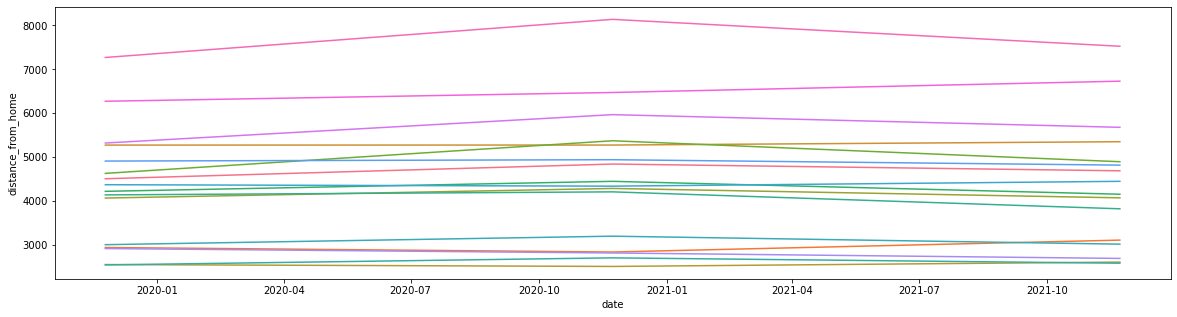

In [90]:
fig, ax = plt.subplots(figsize = (20,5))
sns.lineplot(data = df, x = "date", y = "distance_from_home", hue = "placekey", legend=False)

In [29]:
from shapely.ops import cascaded_union, unary_union

In [28]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, distance):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(distance)  # distance in metres
    return transform(project, buf).exterior.coords[:]



In [91]:
df["circle"] = df.apply(lambda x : geodesic_point_buffer(x.latitude, x.longitude, x.distance_from_home), axis = 1)
df["circle"] = df.circle.apply(Polygon)

In [35]:
df["points"] = df.apply(lambda x : Point(x.longitude, x.latitude), axis = 1)

#### Generating isodistances with the isoline service

In [172]:
from cartoframes.data.services.isolines import Isolines
iso = Isolines()

def generate_isoline(placekey, point, ranges):
    point_gdf = gpd.GeoDataFrame([point], columns = ["geometry"])
    out = iso.isodistances(point_gdf, ranges, geom_col = "geometry").data
    out["placekey"] = placekey
    isolines_list.append(out)

In [100]:
isolines_df = df.groupby("placekey").agg({"distance_from_home" : list, "latitude" : "first",  "longitude" : "first"})

In [102]:
isolines_df["points"] = isolines_df.apply(lambda x : Point(x.longitude, x.latitude), axis = 1)

In [173]:
isolines_list = []
isolines_df.apply(lambda x : generate_isoline(x.name, x.points, x.distance_from_home), axis = 1)

Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly
Success! Isolines created correctly


placekey
222-222@5pw-67x-pjv    None
222-222@5pw-6by-9s5    None
222-222@5pw-6d4-k2k    None
222-222@5pw-6d7-ct9    None
222-223@5pw-2kf-49z    None
222-223@5pw-68x-r49    None
222-223@5pw-6q5-8jv    None
222-224@5pw-6d8-xnq    None
22g-222@5pw-694-vj9    None
22g-222@5pw-6fm-jy9    None
zzw-222@5pw-2nb-5xq    None
zzw-222@5pw-2rc-n89    None
zzw-222@5pw-67j-xkf    None
zzw-222@5sb-7y6-p9z    None
zzw-223@5pw-6rk-snq    None
zzw-224@5pw-2np-g49    None
dtype: object

In [174]:
all_isolines_df = pd.concat(isolines_list)

In [175]:
df.head()

,placekey,date,latitude,longitude,distance_from_home,circle,datetime
0,222-222@5pw-67x-pjv,2019-11-25,41.830883,-87.747152,4506,POLYGON ((-87.69290894945215 41.83087019224907...,2019-11-25
1,222-222@5pw-67x-pjv,2020-11-23,41.830883,-87.747152,4841,POLYGON ((-87.68887619666654 41.83086821706543...,2020-11-23
2,222-222@5pw-67x-pjv,2021-11-22,41.830883,-87.747152,4687,POLYGON ((-87.69073005911029 41.83086914264315...,2021-11-22
3,222-222@5pw-6by-9s5,2019-11-25,41.808860,-87.606953,2939,POLYGON ((-87.57158522496091 41.80885455552506...,2019-11-25
4,222-222@5pw-6by-9s5,2020-11-23,41.808860,-87.606953,2836,POLYGON ((-87.57282472153769 41.80885493045147...,2020-11-23


In [176]:
all_isolines_df = all_isolines_df.rename(columns = {"data_range": "distance_from_home"})

In [177]:
final_isolines_df = pd.merge(df, all_isolines_df, on = ["distance_from_home", "placekey"])

In [44]:
from cartoframes.data.services import utils

In [156]:
df["datetime"] = df.date.apply(lambda x :pd.to_datetime(x))
final_isolines_df["datetime"] = final_isolines_df.date.apply(lambda x :pd.to_datetime(x))

In [162]:
walmart_locations = df[["latitude", "longitude"]].drop_duplicates()
walmart_locations["geometry"] = walmart_locations.apply(lambda x : Point(x.longitude, x.latitude), axis = 1)

In [163]:
l_points = Layer(walmart_locations, 
     geom_col="geometry")

In [186]:
from cartoframes.viz import Layer, animation_style, time_series_widget, popup_element

duration = 10
buckets = len(df.date.unique())

l_isolines = Layer(
    final_isolines_df,
    animation_style('datetime', duration=duration, fade_in=duration/buckets, fade_out=4,
                    stroke_width = 1.5,
                    stroke_color="#11A579",
                    opacity=0),
    geom_col="the_geom",
    popup_hover=popup_element("distance_from_home", title= "Average distance from home (m)"),
    widgets=[
        time_series_widget(
            title = f"Distance From Home to Walmarts - {title_cities.get(city)}",
            description="average distance ",
            value='datetime',
            buckets = 5,
        )]
)


l_circles = Layer(
    df,
    animation_style('datetime', duration=duration, fade_in=duration/buckets, fade_out=4,
                    stroke_width = 1,
                    stroke_color="#11A579",
                    opacity=0),
    geom_col="circle",
    popup_hover=popup_element("distance_from_home", title= "Average distance from home (m)"),
    widgets=[
        time_series_widget(
            title = f"Distance From Home to Walmarts - {title_cities.get(city)}",
            description="average distance ",
            value='datetime',
            buckets = 5,
        )]
)

In [187]:
m = Map([l_points, l_isolines])

In [189]:
m.publish("safegraph_bf_walmart_distance_from_home", None, if_exists="replace")

{'id': 'e9ee725f-acca-4072-baa8-1a8b7a156c7c',
 'url': 'https://team.carto.com/u/juanluisr/kuviz/e9ee725f-acca-4072-baa8-1a8b7a156c7c',
 'name': 'safegraph_bf_walmart_distance_from_home',
 'privacy': 'public'}

In [188]:
m

In [144]:
m.publish("average_distance_to_walmarts_chicago", None)

{'id': '27d4f6e0-44e2-4e60-818a-d600d23bd18c',
 'url': 'https://team.carto.com/u/juanluisr/kuviz/27d4f6e0-44e2-4e60-818a-d600d23bd18c',
 'name': 'average_distance_to_walmarts_chicago',
 'privacy': 'public'}

# DRAFT

In [1481]:
chicago_walmart_visitors.visitor_home_cbgs = chicago_walmart_visitors.visitor_home_cbgs.apply(lambda x : dict(json.loads(x)))

In [1482]:
chicago_visitors.visitor_home_cbgs = chicago_visitors.visitor_home_cbgs.apply(lambda x : dict(json.loads(x)))

In [1263]:
a = {"zone1" : 2, "zone2" : 4, "zone3" : 9}
b = {"zone1" : 3, "zone2" : 2, "zone4" : 7}

In [1494]:
def merge_dicts(a,b):
    a_and_b =  {k: a[k] + b[k] for k in set(a).intersection(set(b))}
    c = a.copy()
    c.update(b), c.update(a_and_b)
    return c
     

In [1265]:
from functools import reduce

In [1485]:
visitors_bf_2019 = chicago_visitors[chicago_visitors.date.apply(lambda x : x.year == 2019)].visitor_home_cbgs

In [1507]:
visitors_bf_2019_walmart = chicago_walmart_visitors[chicago_walmart_visitors.date.apply(lambda x : x.year == 2019)].visitor_home_cbgs
visitors_bf_2020_walmart = chicago_walmart_visitors[chicago_walmart_visitors.date.apply(lambda x : x.year == 2020)].visitor_home_cbgs

In [1276]:
import time

In [1495]:
start = time.perf_counter()
all_pois_out = reduce(merge_dicts, visitors_bf_2019)
end = time.perf_counter() - start

In [1508]:
start = time.perf_counter()
walmart_out = reduce(merge_dicts, visitors_bf_2019_walmart)
end = time.perf_counter() - start
start = time.perf_counter()
walmart_out_2020 = reduce(merge_dicts, visitors_bf_2020_walmart)
end = time.perf_counter() - start

In [1501]:
home_blockgroups_on_hotspot_areas = pd.DataFrame([all_pois_out], index = ["visitor_homes"]).T
home_blockgroups_gdf = pd.merge(home_blockgroups_on_hotspot_areas, blockgroups_gdf.set_index("geoid"), right_index=True, left_index=True)
q95_visitor_homes = home_blockgroups_gdf.visitor_homes.quantile(0.95)

In [1532]:
home_blockgroups_on_hotspot_areas_walmart = pd.DataFrame([walmart_out], index = ["visitor_homes"]).T
home_blockgroups_walmart_gdf = pd.merge(home_blockgroups_on_hotspot_areas_walmart, blockgroups_gdf.set_index("geoid"), right_index=True, left_index=True)
q95_visitor_homes_w = home_blockgroups_walmart_gdf.visitor_homes.quantile(0.95)

home_blockgroups_on_hotspot_areas_walmart_2020 = pd.DataFrame([walmart_out_2020], index = ["visitor_homes"]).T
home_blockgroups_walmart_gdf_2020 = pd.merge(home_blockgroups_on_hotspot_areas_walmart_2020, blockgroups_gdf.set_index("geoid"), right_index=True, left_index=True)
q95_visitor_homes_w_2020 = home_blockgroups_walmart_gdf_2020.visitor_homes.quantile(0.99)

In [1544]:
visitor_homes_walmart_layer_2019 = \
Layer(home_blockgroups_walmart_gdf, 
     title= "Walmart 2019",
     style = color_continuous_style("visitor_homes", range_max=q95_visitor_homes_w_2020, palette = "Teal", opacity=0.8),
     geom_col = "geometry")
visitor_homes_walmart_layer_2020 = \
Layer(home_blockgroups_walmart_gdf_2020,
     title= "Walmart 2020", 
     style = color_continuous_style("visitor_homes", range_max=q95_visitor_homes_w_2020, palette = "Teal", opacity=0.8),
     geom_col = "geometry")

In [1542]:
q95_visitor_homes_w_2020 = home_blockgroups_walmart_gdf_2020.visitor_homes.quantile(0.99)

In [1504]:
visitor_homes_layer = \
Layer(home_blockgroups_gdf, 
     style = color_continuous_style("visitor_homes", range_max=q95_visitor_homes, palette = "Teal", opacity=0.8),
     geom_col = "geometry")

In [114]:
walmart_layer = Layer(gdf_walmart, 
      style = size_bins_style("raw_visitor_counts"),
      geom_col = "geometry")

In [1522]:
from cartoframes.viz import Layout

In [1725]:
layout_walmart = Layout([m_2019, m_2020],
        map_height = 500)

In [94]:
walmart_bf = chicago_walmart_visitors.copy()

In [254]:
from cartoframes.viz import category_widget, popup_element

In [99]:
walmart_visits.to_csv("walmart_visitor_home_cbgs_count_chicago.csv")
